In [1]:
import pandas as pd
from datetime import date
import numpy as np
import seaborn as sns
from datetime import date
from datetime import timedelta
import os
import json
import hvplot.pandas
import yfinance as yf
from io import BytesIO
import requests
from twilio.rest import Client
from dotenv import load_dotenv
import panel as pn
pn.extension('')
import subprocess
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from IPython.display import Markdown
# import pyflux as pf
import hvplot.pandas
from sklearn.metrics import classification_report
import yliveticker
import alpaca_trade_api as tradeapi
import requests




In [2]:
csv_path = Path('Resources/2018_stocks_data.csv')
apple_earning_path = Path('Resources/apple_earning - Sheet1.csv')
apple_launch_path = Path('Resources/iphone_launch - Sheet1.csv')

In [3]:
stocks = pd.read_csv(csv_path, header=0, index_col=0).dropna(how='all', axis=1)
apple_earning = pd.read_csv(apple_earning_path, index_col=0)
iphone_launch = pd.read_csv(apple_launch_path, index_col=0)

In [4]:
def set_stocks():
    return stocks

In [5]:
set_stocks().head()

AAPL         SPY         GOOG        TSM        NVDA  \
Date                                                                    
2018-01-02  43.064999  268.769989  1065.000000  41.020000  199.350006   
2018-01-03  43.057499  270.470001  1082.479980  41.709999  212.470001   
2018-01-04  43.257500  271.609985  1086.400024  41.490002  213.589996   
2018-01-05  43.750000  273.420013  1102.229980  42.459999  215.399994   
2018-01-08  43.587502  273.920013  1106.939941  42.439999  222.000000   

                 MSFT       PYPL         VGT         AMZN         IBM  \
Date                                                                    
2018-01-02  85.949997  73.839996  166.979996  1189.010010  154.250000   
2018-01-03  86.349998  76.750000  168.720001  1204.199951  158.490005   
2018-01-04  87.110001  76.730003  169.690002  1209.589966  161.699997   
2018-01-05  88.190002  78.699997  171.500000  1229.140015  162.490005   
2018-01-08  88.279999  79.050003  172.320007  1246.869995  163.470001   

                  NFLX        HPQ       SONY       DELL  
Date                                                     
2018-01-02  201.070007  21.320000  45.790001  45.642303  
2018-01-03  205.050003  21.370001  46.299999  46.124031  
2018-01-04  205.630005  21.530001  47.250000  46.943523  
2018-01-05  209.990005  21.750000  48.700001  47.286823  
2018-01-08  212.050003  21.840000  49.000000  47.275749

In [6]:
def get_stocks_list():
    return stocks.columns.tolist()

In [7]:
get_stocks_list()

['AAPL',
 'SPY',
 'GOOG',
 'TSM',
 'NVDA',
 'MSFT',
 'PYPL',
 'VGT',
 'AMZN',
 'IBM',
 'NFLX',
 'HPQ',
 'SONY',
 'DELL']

In [8]:
def get_stocks_pct_change():
    result = set_stocks().pct_change()
    result.dropna(inplace=True)
    return result

In [9]:
def make_interpretations():
    aapl_pct_change = pd.DataFrame()
    aapl_pct_change['AAPL'] = (get_stocks_pct_change())['AAPL']
    for index, row in aapl_pct_change.iterrows():
        if(row['AAPL']>=0):
            aapl_pct_change.at[index,'Positive']=1
            aapl_pct_change.at[index,'Negative']=0
        else:
            aapl_pct_change.at[index,'Negative']=1
            aapl_pct_change.at[index,'Positive']=0

    return aapl_pct_change

In [10]:
make_interpretations().head(10)

AAPL  Negative  Positive
Date                                    
2018-01-03 -0.000174       1.0       0.0
2018-01-04  0.004645       0.0       1.0
2018-01-05  0.011385       0.0       1.0
2018-01-08 -0.003714       1.0       0.0
2018-01-09 -0.000115       1.0       0.0
2018-01-10 -0.000229       1.0       0.0
2018-01-11  0.005680       0.0       1.0
2018-01-12  0.010326       0.0       1.0
2018-01-16 -0.005082       1.0       0.0
2018-01-17  0.016516       0.0       1.0

In [11]:
apple_earning.head()

Quarter End  Estimated EPS  Actual EPS  Result
Date                                                     
2015-01-27  2014-12-31           0.65        0.77    1.18
2015-04-27  2015-03-31           0.55        0.58    1.05
2015-07-21  2015-06-30           0.45        0.46    1.02
2015-10-27  2015-09-30           0.47        0.49    1.04
2016-01-26  2015-12-31           0.81        0.82    1.01

In [12]:
iphone_launch.head()

iphone
Date              
2007-06-29       1
2008-07-11       1
2010-06-24       1
2012-09-21       1
2014-09-19       1

In [13]:
def set_lags():
    stocks_df = set_stocks().copy()

    for stock in get_stocks_list():
        stocks_df[stock+' Lag'] = stocks_df[stock].shift()
        if (stock!='AAPL'):
            stocks_df.drop(columns=stock, inplace=True)
    stocks_df.dropna(inplace=True)
    return stocks_df

In [14]:
def set_apple_info():
    apple_info = apple_earning.join(iphone_launch, how='outer')
    apple_info.drop(['Quarter End','Estimated EPS','Actual EPS'], axis=1, inplace=True)
    return apple_info

In [15]:
def combine_lags_appleInfo():
    combined_df = set_lags()
    combined_df = combined_df.join(set_apple_info(), how='outer')
    combined_df = combined_df[combined_df['AAPL'].notna()]
    combined_df['iphone'].fillna(0, inplace=True)
    combined_df['Result'].fillna(1, inplace=True)
    return combined_df

In [16]:
combine_lags_appleInfo().head()

AAPL   AAPL Lag     SPY Lag     GOOG Lag    TSM Lag  \
Date                                                                   
2018-01-03  43.057499  43.064999  268.769989  1065.000000  41.020000   
2018-01-04  43.257500  43.057499  270.470001  1082.479980  41.709999   
2018-01-05  43.750000  43.257500  271.609985  1086.400024  41.490002   
2018-01-08  43.587502  43.750000  273.420013  1102.229980  42.459999   
2018-01-09  43.582500  43.587502  273.920013  1106.939941  42.439999   

              NVDA Lag   MSFT Lag   PYPL Lag     VGT Lag     AMZN Lag  \
Date                                                                    
2018-01-03  199.350006  85.949997  73.839996  166.979996  1189.010010   
2018-01-04  212.470001  86.349998  76.750000  168.720001  1204.199951   
2018-01-05  213.589996  87.110001  76.730003  169.690002  1209.589966   
2018-01-08  215.399994  88.190002  78.699997  171.500000  1229.140015   
2018-01-09  222.000000  88.279999  79.050003  172.320007  1246.869995   

               IBM Lag    NFLX Lag    HPQ Lag   SONY Lag   DELL Lag  Result  \
Date                                                                          
2018-01-03  154.250000  201.070007  21.320000  45.790001  45.642303     1.0   
2018-01-04  158.490005  205.050003  21.370001  46.299999  46.124031     1.0   
2018-01-05  161.699997  205.630005  21.530001  47.250000  46.943523     1.0   
2018-01-08  162.490005  209.990005  21.750000  48.700001  47.286823     1.0   
2018-01-09  163.470001  212.050003  21.840000  49.000000  47.275749     1.0   

            iphone  
Date                
2018-01-03     0.0  
2018-01-04     0.0  
2018-01-05     0.0  
2018-01-08     0.0  
2018-01-09     0.0

In [17]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i: (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [18]:
def getSampleValues_stocks():
    # Creating the features (X) and target (y) data using the window_data() function.
    window_size = 5
    feature_column = 0
    target_column = 0
    X, y = window_data(combine_lags_appleInfo(), window_size, feature_column, target_column)
    return X,y

In [19]:
getSampleValues_stocks()

(array([[ 43.05749893,  43.25749969,  43.75      ,  43.58750153,
          43.58250046],
        [ 43.25749969,  43.75      ,  43.58750153,  43.58250046,
          43.57249832],
        [ 43.75      ,  43.58750153,  43.58250046,  43.57249832,
          43.81999969],
        ...,
        [136.33000183, 136.96000671, 137.27000427, 139.96000671,
         142.02000427],
        [136.96000671, 137.27000427, 139.96000671, 142.02000427,
         144.57000732],
        [137.27000427, 139.96000671, 142.02000427, 144.57000732,
         143.24000549]]),
 array([[ 43.57249832],
        [ 43.81999969],
        [ 44.27249908],
        [ 44.04750061],
        [ 44.77500153],
        [ 44.81499863],
        [ 44.61500168],
        [ 44.25      ],
        [ 44.25999832],
        [ 43.55500031],
        [ 42.77750015],
        [ 42.87749863],
        [ 41.99000168],
        [ 41.74250031],
        [ 41.85749817],
        [ 41.94499969],
        [ 40.125     ],
        [ 39.12250137],
        [ 40.757499

In [20]:
def getTestingData_stocks(percent_training=70/100):
    # Use 70% of the data for training and the remainder for testing
    X, y = getSampleValues_stocks()
    split = int(percent_training * len(X))
    X_train = X[: split]
    X_test = X[split:]
    y_train = y[: split]
    y_test = y[split:]
    return X_train, X_test, y_train, y_test

In [21]:
getTestingData_stocks()

(array([[43.05749893, 43.25749969, 43.75      , 43.58750153, 43.58250046],
        [43.25749969, 43.75      , 43.58750153, 43.58250046, 43.57249832],
        [43.75      , 43.58750153, 43.58250046, 43.57249832, 43.81999969],
        ...,
        [83.97499847, 84.69999695, 85.74749756, 88.01999664, 87.89749908],
        [84.69999695, 85.74749756, 88.01999664, 87.89749908, 87.93250275],
        [85.74749756, 88.01999664, 87.89749908, 87.93250275, 87.43000031]]),
 array([[ 88.01999664,  87.89749908,  87.93250275,  87.43000031,
          89.71749878],
        [ 87.89749908,  87.93250275,  87.43000031,  89.71749878,
          91.63249969],
        [ 87.93250275,  87.43000031,  89.71749878,  91.63249969,
          90.01499939],
        ...,
        [136.33000183, 136.96000671, 137.27000427, 139.96000671,
         142.02000427],
        [136.96000671, 137.27000427, 139.96000671, 142.02000427,
         144.57000732],
        [137.27000427, 139.96000671, 142.02000427, 144.57000732,
         143

In [22]:
def scale_TestingData_stocks():
    X, y = getSampleValues_stocks()
    X_train, X_test, y_train, y_test = getTestingData_stocks()
    scaler = MinMaxScaler()
    scaler.fit(X)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    scaler.fit(y)
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)
    return X_train, X_test, y_train, y_test, scaler

In [23]:
scale_TestingData_stocks()

(array([[0.06978741, 0.07164594, 0.07622255, 0.07374625, 0.07370038],
        [0.07164594, 0.07622255, 0.07471252, 0.07370038, 0.07360863],
        [0.07622255, 0.07471252, 0.07466604, 0.07360863, 0.07587882],
        ...,
        [0.45001739, 0.45675451, 0.46648852, 0.48129967, 0.48017607],
        [0.45675451, 0.46648852, 0.48760594, 0.48017607, 0.48049714],
        [0.46648852, 0.48760594, 0.48646762, 0.48049714, 0.47588797]]),
 array([[0.48760594, 0.48646762, 0.4867929 , 0.47588797, 0.49686986],
        [0.48646762, 0.4867929 , 0.48212334, 0.49686986, 0.51443505],
        [0.4867929 , 0.48212334, 0.50338015, 0.51443505, 0.49959866],
        ...,
        [0.93653152, 0.94238591, 0.94526659, 0.95771515, 0.97661031],
        [0.94238591, 0.94526659, 0.97026371, 0.97661031, 1.        ],
        [0.94526659, 0.97026371, 0.98940644, 1.        , 0.98780067]]),
 array([[0.07324584],
        [0.07550484],
        [0.0796349 ],
        [0.07758129],
        [0.08422134],
        [0.08458641]

In [24]:
def reshapeFeatures_stocks():
    X_train, X_test, y_train, y_test, scaler = scale_TestingData_stocks()
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    # print(f"X_train sample values:\n{X_train[:5]} \n")
    # print(f"X_test sample values:\n{X_test[:5]}")
    return X_train, X_test, y_train, y_test, scaler

In [25]:
reshapeFeatures_stocks()

(array([[[0.06978741],
         [0.07164594],
         [0.07622255],
         [0.07374625],
         [0.07370038]],
 
        [[0.07164594],
         [0.07622255],
         [0.07471252],
         [0.07370038],
         [0.07360863]],
 
        [[0.07622255],
         [0.07471252],
         [0.07466604],
         [0.07360863],
         [0.07587882]],
 
        ...,
 
        [[0.45001739],
         [0.45675451],
         [0.46648852],
         [0.48129967],
         [0.48017607]],
 
        [[0.45675451],
         [0.46648852],
         [0.48760594],
         [0.48017607],
         [0.48049714]],
 
        [[0.46648852],
         [0.48760594],
         [0.48646762],
         [0.48049714],
         [0.47588797]]]),
 array([[[0.48760594],
         [0.48646762],
         [0.4867929 ],
         [0.47588797],
         [0.49686986]],
 
        [[0.48646762],
         [0.4867929 ],
         [0.48212334],
         [0.49686986],
         [0.51443505]],
 
        [[0.4867929 ],
         [0.482123

In [26]:
def set_LSTM_RNN_stocks_model():
    X_train, X_test, y_train, y_test, scaler = reshapeFeatures_stocks()
    model = Sequential()

    number_units = 5
    dropout_fraction = 0.2

    # Layer 1
    model.add(LSTM(units=20,return_sequences=True,input_shape=(X_train.shape[1], 1),activation = 'linear'))
    model.add(Dropout(dropout_fraction))
    #     # Layer 2
    model.add(LSTM(units=15, return_sequences=True,activation = 'linear'))
    model.add(Dropout(dropout_fraction))
    #     # Layer 3
    #     model.add(ml.LSTM(units=number_units))
    #     model.add(ml.Dropout(dropout_fraction))
    # Output layer
    model.add(Flatten())
    model.add(Dense(1))

    print('step 1. compile the model')
    #     model.compile(optimizer="adam", loss="mean_absolute_percentage_error"), X_train, X_test, y_train, y_test, scaler
    model.compile(optimizer="adam", loss="mean_squared_error"), X_train, X_test, y_train, y_test, scaler

    print('step 2. model summary')
    model.summary()

    print('step 3. Train the model')
    model.fit(X_train, y_train, epochs=35, shuffle=False, batch_size=1, verbose=1)
    print('step 4. Evaluate the model')
    model.evaluate(X_test, y_test)

    return model, X_train, X_test, y_train, y_test, scaler

In [27]:
def get_predictions_stocks():
    model, X_train, X_test, y_train, y_test, scaler = set_LSTM_RNN_stocks_model()
    # Make some predictions
    predicted = model.predict(X_test)

    predicted_prices = scaler.inverse_transform(predicted)
    real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
    # Create a DataFrame of Real and Predicted values
    stocks_predict = pd.DataFrame({
        "Real": real_prices.ravel(),
        "Predicted": predicted_prices.ravel()
    }, index=set_stocks().index[-len(real_prices):])

    return stocks_predict

step 1. compile the model
step 2. model summary
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 20)             1760      
_________________________________________________________________
dropout (Dropout)            (None, 5, 20)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 15)             2160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 15)             0         
_________________________________________________________________
flatten (Flatten)            (None, 75)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 76        
Total params: 3,996
Trainable params: 3,996
Non-trainable params: 0
______

<AxesSubplot:xlabel='Date'>

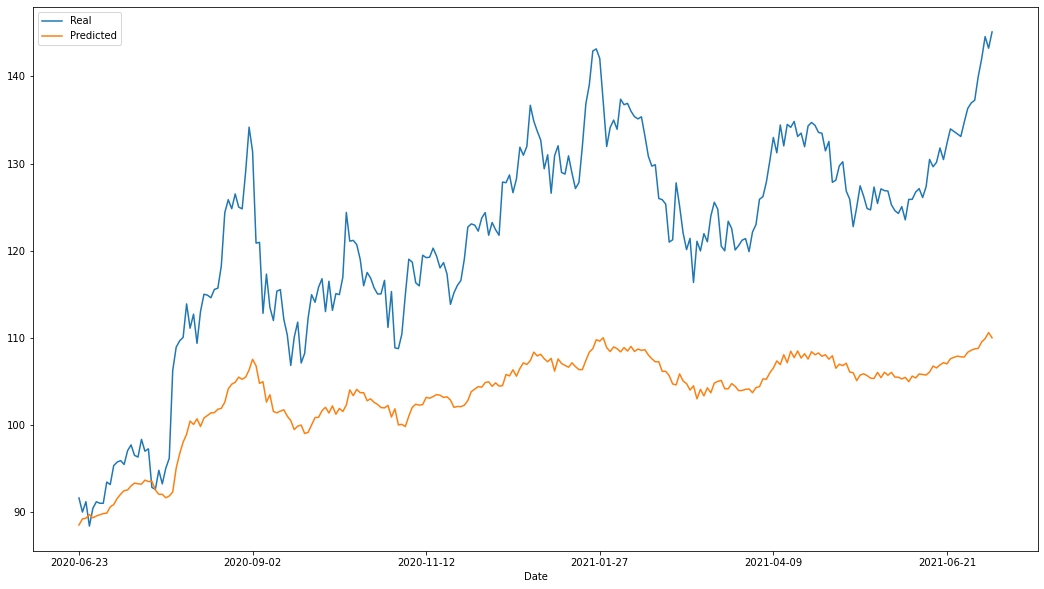

In [28]:
predictions = get_predictions_stocks()
predictions.plot(figsize=(18, 10))

In [29]:
predictions

Real   Predicted
Date                              
2020-06-23   91.632500   88.532127
2020-06-24   90.014999   89.232773
2020-06-25   91.209999   89.316078
2020-06-26   88.407501   89.732040
2020-06-29   90.445000   89.358116
...                ...         ...
2021-07-02  139.960007  108.792778
2021-07-06  142.020004  109.533142
2021-07-07  144.570007  109.913246
2021-07-08  143.240005  110.611496
2021-07-09  145.110001  110.012444

[264 rows x 2 columns]

In [30]:
def make_model_interpretations(predictions):
    predictions_pct_change=predictions.pct_change()
    predictions_pct_change.dropna(inplace=True)

    return predictions_pct_change

In [31]:
make_model_interpretations(predictions)

Real  Predicted
Date                           
2020-06-24 -0.017652   0.007914
2020-06-25  0.013276   0.000934
2020-06-26 -0.030726   0.004657
2020-06-29  0.023047  -0.004167
2020-06-30  0.008348   0.002300
...              ...        ...
2021-07-02  0.019596   0.000425
2021-07-06  0.014718   0.006805
2021-07-07  0.017955   0.003470
2021-07-08 -0.009200   0.006353
2021-07-09  0.013055  -0.005416

[263 rows x 2 columns]

In [32]:
trade_df = make_model_interpretations(predictions)
trade_df.loc[trade_df['Real'] < 0, 'Real_trade'] = round(int(0),1) 
trade_df.loc[trade_df['Real'] >= 0, 'Real_trade'] = round(int(1),1)
trade_df.loc[trade_df['Predicted'] < 0, 'Predicted_trade'] = round(int(0),1) 
trade_df.loc[trade_df['Predicted'] >= 0, 'Predicted_trade'] = round(int(1),1) 

In [33]:
trade_df.head(100)

Real  Predicted  Real_trade  Predicted_trade
Date                                                        
2020-06-24 -0.017652   0.007914         0.0              1.0
2020-06-25  0.013276   0.000934         1.0              1.0
2020-06-26 -0.030726   0.004657         0.0              1.0
2020-06-29  0.023047  -0.004167         1.0              0.0
2020-06-30  0.008348   0.002300         1.0              1.0
...              ...        ...         ...              ...
2020-11-06 -0.002856   0.010024         0.0              1.0
2020-11-09 -0.019968   0.003455         0.0              1.0
2020-11-10 -0.003009  -0.001042         0.0              0.0
2020-11-11  0.030353   0.000599         1.0              1.0
2020-11-12 -0.002343   0.008161         0.0              1.0

[100 rows x 4 columns]

In [34]:
from sklearn.metrics import classification_report

y_true = trade_df['Real_trade'].tolist()
y_pred = trade_df['Predicted_trade'].tolist()
report = classification_report(y_true=y_true, y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.39      0.37      0.38       123
         1.0       0.48      0.51      0.49       140

    accuracy                           0.44       263
   macro avg       0.44      0.44      0.44       263
weighted avg       0.44      0.44      0.44       263



In [35]:
def plot_correlations(param_ax=None):
    correlation = (get_stocks_pct_change()).corr()
    # Display de correlation matrix
    plt.rcParams['figure.figsize'] = (25.0, 10.0)
    plt.rcParams['font.family'] = "consolas"
    plt.rcParams.update({'font.size': 20})

    return sns.heatmap(correlation, annot=True, vmin=-1, vmax=1, annot_kws={'size': 25}, ax=param_ax)

findfont: Font family ['consolas'] not found. Falling back to DejaVu Sans.


<AxesSubplot:>

findfont: Font family ['consolas'] not found. Falling back to DejaVu Sans.


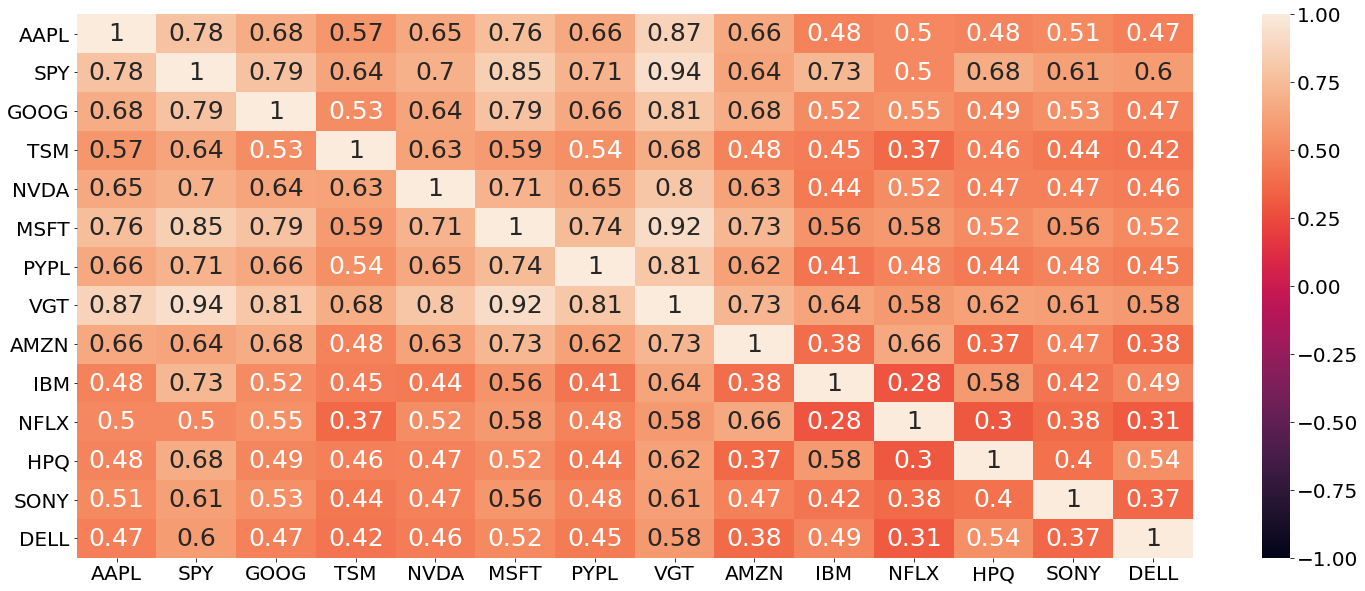

In [36]:
plot_correlations()

In [37]:
def get_appl_data(start_date = "2016-01-01"):
    aapl_df = yf.download("AAPL", start=start_date,progress=False)
    aapl_df.reset_index(level=0, inplace=True)
    return aapl_df

In [38]:
get_appl_data()

Date        Open        High         Low       Close   Adj Close  \
0    2016-01-04   25.652500   26.342501   25.500000   26.337500   24.323219   
1    2016-01-05   26.437500   26.462500   25.602501   25.677500   23.713696   
2    2016-01-06   25.139999   25.592501   24.967501   25.174999   23.249626   
3    2016-01-07   24.670000   25.032499   24.107500   24.112499   22.268383   
4    2016-01-08   24.637501   24.777500   24.190001   24.240000   22.386133   
...         ...         ...         ...         ...         ...         ...   
1388 2021-07-09  142.750000  145.649994  142.649994  145.110001  145.110001   
1389 2021-07-12  146.210007  146.320007  144.000000  144.500000  144.500000   
1390 2021-07-13  144.029999  147.460007  143.630005  145.639999  145.639999   
1391 2021-07-14  148.100006  149.570007  147.679993  149.149994  149.149994   
1392 2021-07-15  149.240005  150.000000  147.095001  148.179993  148.179993   

         Volume  
0     270597600  
1     223164000  
2     273829600  
3     324377600  
4     283192000  
...         ...  
1388   99788400  
1389   76299700  
1390  100698900  
1391  126871000  
1392   91450229  

[1393 rows x 7 columns]

In [39]:
import io
test_predictions = predictions
test_predictions.index = pd.to_datetime(test_predictions.index)
test_predictions

Real   Predicted
Date                              
2020-06-23   91.632500   88.532127
2020-06-24   90.014999   89.232773
2020-06-25   91.209999   89.316078
2020-06-26   88.407501   89.732040
2020-06-29   90.445000   89.358116
...                ...         ...
2021-07-02  139.960007  108.792778
2021-07-06  142.020004  109.533142
2021-07-07  144.570007  109.913246
2021-07-08  143.240005  110.611496
2021-07-09  145.110001  110.012444

[264 rows x 2 columns]

In [40]:
test = get_appl_data()
test = test.set_index('Date')
test.index = pd.to_datetime(test.index)

In [41]:
test 

Open        High         Low       Close   Adj Close  \
Date                                                                     
2016-01-04   25.652500   26.342501   25.500000   26.337500   24.323219   
2016-01-05   26.437500   26.462500   25.602501   25.677500   23.713696   
2016-01-06   25.139999   25.592501   24.967501   25.174999   23.249626   
2016-01-07   24.670000   25.032499   24.107500   24.112499   22.268383   
2016-01-08   24.637501   24.777500   24.190001   24.240000   22.386133   
...                ...         ...         ...         ...         ...   
2021-07-09  142.750000  145.649994  142.649994  145.110001  145.110001   
2021-07-12  146.210007  146.320007  144.000000  144.500000  144.500000   
2021-07-13  144.029999  147.460007  143.630005  145.639999  145.639999   
2021-07-14  148.100006  149.570007  147.679993  149.149994  149.149994   
2021-07-15  149.240005  150.000000  147.095001  148.179993  148.179993   

               Volume  
Date                   
2016-01-04  270597600  
2016-01-05  223164000  
2016-01-06  273829600  
2016-01-07  324377600  
2016-01-08  283192000  
...               ...  
2021-07-09   99788400  
2021-07-12   76299700  
2021-07-13  100698900  
2021-07-14  126871000  
2021-07-15   91450229  

[1393 rows x 6 columns]

In [42]:
combined_test = pd.concat([test_predictions, test], axis=1, join="inner")
combined_test['Close']=combined_test['Predicted']
combined_test = combined_test.drop(['Real', 'Predicted'], axis=1)
combined_test

Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-06-23   91.000000   93.095001   90.567497   88.532127   91.019203   
2020-06-24   91.250000   92.197502   89.629997   89.232773   89.412537   
2020-06-25   90.175003   91.250000   89.392502   89.316078   90.599533   
2020-06-26   91.102501   91.330002   88.254997   89.732040   87.815788   
2020-06-29   88.312500   90.542503   87.820000   89.358116   89.839653   
...                ...         ...         ...         ...         ...   
2021-07-02  137.899994  140.000000  137.750000  108.792778  139.960007   
2021-07-06  140.070007  143.149994  140.070007  109.533142  142.020004   
2021-07-07  143.539993  144.889999  142.660004  109.913246  144.570007   
2021-07-08  141.580002  144.059998  140.669998  110.611496  143.240005   
2021-07-09  142.750000  145.649994  142.649994  110.012444  145.110001   

               Volume  
Date                   
2020-06-23  212155600  
2020-06-24  192623200  
2020-06-25  137522400  
2020-06-26  205256800  
2020-06-29  130646000  
...               ...  
2021-07-02   78852600  
2021-07-06  108181800  
2021-07-07  104911600  
2021-07-08  105575500  
2021-07-09   99788400  

[264 rows x 6 columns]

In [43]:
def get_aapl_signals(short_window = 10, long_window = 20):
    aapl_df = combined_test
    aapl_df = aapl_df.reset_index()
    # Grab just the `date` and `close` from the dataset
    signals_df = aapl_df.loc[:, ["Date", "Close"]].copy()
    # Set the `date` column as the index
    signals_df = signals_df.set_index("Date", drop=True)
    # Generate the short and long moving averages (10 and 20 days, respectively)
    signals_df["SMA10"] = signals_df["Close"].rolling(window=short_window).mean()
    signals_df["SMA20"] = signals_df["Close"].rolling(window=long_window).mean()
    signals_df["Signal"] = 0.0
    signals_df = signals_df.dropna()
    # Generate the trading signal 0 or 1,
    # where 0 is when the SMA10 is under the SMA20, and
    # where 1 is when the SMA10 is higher (or crosses over) the SMA20
    signals_df["Signal"][short_window:] = np.where(
        signals_df["SMA10"][short_window:] > signals_df["SMA20"][short_window:], 1.0, 0.0
    )

    # Calculate the points in time at which a position should be taken, 1 or -1
    signals_df["Entry/Exit"] = signals_df["Signal"].diff()
#     signals_df = signals_df.reset_index()
    return signals_df

In [44]:
get_aapl_signals().head(10)

Close      SMA10      SMA20  Signal  Entry/Exit
Date                                                           
2020-07-21  93.684273  92.607610  91.093156     0.0         NaN
2020-07-22  93.516731  92.871961  91.342386     0.0         0.0
2020-07-23  93.558601  93.070075  91.558677     0.0         0.0
2020-07-24  92.551346  93.118444  91.720441     0.0         0.0
2020-07-27  92.056938  93.076997  91.836686     0.0         0.0
2020-07-28  92.052032  93.026922  91.971381     0.0         0.0
2020-07-29  91.660362  92.890250  92.076218     0.0         0.0
2020-07-30  91.858521  92.741815  92.183598     0.0         0.0
2020-07-31  92.319931  92.648195  92.307501     0.0         0.0
2020-08-03  95.054367  92.831310  92.565676     0.0         0.0

In [45]:
def aapl_signals_plot():
    signals_df = get_aapl_signals().copy()

    # Visualize exit position relative to close price
    exit = signals_df[signals_df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
        color='red',
        marker='v',
        size=200,
        legend=False,
        ylabel='Price in $',
        width=1000,
        height=400
    )

    # Visualize entry position relative to close price
    entry = signals_df[signals_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
        color='green',
        marker='^',
        size=200,
        legend=False,
        ylabel='Price in $',
        width=1000,
        height=400
    )

    # Visualize close price for the investment
    security_close = signals_df[['Close']].hvplot(
        line_color='lightgray',
        ylabel='Price in $',
        width=1000,
        height=400
    )

    # Visualize moving averages
    moving_avgs = signals_df[['SMA10', 'SMA20']].hvplot(
        ylabel='Price in $',
        width=1000,
        height=400
    )

    # Overlay plots
    entry_exit_plot = security_close * moving_avgs * entry * exit
    return entry_exit_plot.opts(xaxis=None)

In [46]:
aapl_signals_plot()

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [47]:
appl_signals_mixed = get_aapl_signals()

In [48]:
appl_signals_mixed

Close       SMA10       SMA20  Signal  Entry/Exit
Date                                                              
2020-07-21   93.684273   92.607610   91.093156     0.0         NaN
2020-07-22   93.516731   92.871961   91.342386     0.0         0.0
2020-07-23   93.558601   93.070075   91.558677     0.0         0.0
2020-07-24   92.551346   93.118444   91.720441     0.0         0.0
2020-07-27   92.056938   93.076997   91.836686     0.0         0.0
...                ...         ...         ...     ...         ...
2021-07-02  108.792778  108.041083  107.115769     1.0         0.0
2021-07-06  109.533142  108.292655  107.311373     1.0         0.0
2021-07-07  109.913246  108.523112  107.536908     1.0         0.0
2021-07-08  110.611496  108.807457  107.774028     1.0         0.0
2021-07-09  110.012444  109.017830  107.984469     1.0         0.0

[245 rows x 5 columns]

In [49]:
test

Open        High         Low       Close   Adj Close  \
Date                                                                     
2016-01-04   25.652500   26.342501   25.500000   26.337500   24.323219   
2016-01-05   26.437500   26.462500   25.602501   25.677500   23.713696   
2016-01-06   25.139999   25.592501   24.967501   25.174999   23.249626   
2016-01-07   24.670000   25.032499   24.107500   24.112499   22.268383   
2016-01-08   24.637501   24.777500   24.190001   24.240000   22.386133   
...                ...         ...         ...         ...         ...   
2021-07-09  142.750000  145.649994  142.649994  145.110001  145.110001   
2021-07-12  146.210007  146.320007  144.000000  144.500000  144.500000   
2021-07-13  144.029999  147.460007  143.630005  145.639999  145.639999   
2021-07-14  148.100006  149.570007  147.679993  149.149994  149.149994   
2021-07-15  149.240005  150.000000  147.095001  148.179993  148.179993   

               Volume  
Date                   
2016-01-04  270597600  
2016-01-05  223164000  
2016-01-06  273829600  
2016-01-07  324377600  
2016-01-08  283192000  
...               ...  
2021-07-09   99788400  
2021-07-12   76299700  
2021-07-13  100698900  
2021-07-14  126871000  
2021-07-15   91450229  

[1393 rows x 6 columns]

In [50]:
test = test.rename(columns={"Close": "Close_Real"})
test

Open        High         Low  Close_Real   Adj Close  \
Date                                                                     
2016-01-04   25.652500   26.342501   25.500000   26.337500   24.323219   
2016-01-05   26.437500   26.462500   25.602501   25.677500   23.713696   
2016-01-06   25.139999   25.592501   24.967501   25.174999   23.249626   
2016-01-07   24.670000   25.032499   24.107500   24.112499   22.268383   
2016-01-08   24.637501   24.777500   24.190001   24.240000   22.386133   
...                ...         ...         ...         ...         ...   
2021-07-09  142.750000  145.649994  142.649994  145.110001  145.110001   
2021-07-12  146.210007  146.320007  144.000000  144.500000  144.500000   
2021-07-13  144.029999  147.460007  143.630005  145.639999  145.639999   
2021-07-14  148.100006  149.570007  147.679993  149.149994  149.149994   
2021-07-15  149.240005  150.000000  147.095001  148.179993  148.179993   

               Volume  
Date                   
2016-01-04  270597600  
2016-01-05  223164000  
2016-01-06  273829600  
2016-01-07  324377600  
2016-01-08  283192000  
...               ...  
2021-07-09   99788400  
2021-07-12   76299700  
2021-07-13  100698900  
2021-07-14  126871000  
2021-07-15   91450229  

[1393 rows x 6 columns]

In [51]:
combined_mixed = pd.concat([appl_signals_mixed, test], axis=1, join="inner")
combined_mixed['Close']=combined_mixed['Close_Real']
combined_mixed = combined_mixed.drop(['Open', 'High','Low','Close_Real','Volume'], axis=1)
combined_mixed

Close       SMA10       SMA20  Signal  Entry/Exit   Adj Close
Date                                                                          
2020-07-21   97.000000   92.607610   91.093156     0.0         NaN   96.350784
2020-07-22   97.272499   92.871961   91.342386     0.0         0.0   96.621452
2020-07-23   92.845001   93.070075   91.558677     0.0         0.0   92.223587
2020-07-24   92.614998   93.118444   91.720441     0.0         0.0   91.995125
2020-07-27   94.809998   93.076997   91.836686     0.0         0.0   94.175430
...                ...         ...         ...     ...         ...         ...
2021-07-02  139.960007  108.041083  107.115769     1.0         0.0  139.960007
2021-07-06  142.020004  108.292655  107.311373     1.0         0.0  142.020004
2021-07-07  144.570007  108.523112  107.536908     1.0         0.0  144.570007
2021-07-08  143.240005  108.807457  107.774028     1.0         0.0  143.240005
2021-07-09  145.110001  109.017830  107.984469     1.0         0.0  145.110001

[245 rows x 6 columns]

In [52]:
def analyze_aapl_signals():
#     signals_df = get_aapl_signals().copy()
    signals_df = combined_mixed
    # Set initial capital
    initial_capital = float(100000)

    # Set the share size
    share_size = 500

    # Take a 500 share position where the dual moving average crossover is 1 (SMA50 is greater than SMA100)
    signals_df['Position'] = share_size * signals_df['Signal']

    # Find the points in time where a 500 share position is bought or sold
    signals_df['Entry/Exit Position'] = signals_df['Position'].diff()

    # Multiply share price by entry/exit positions and get the cumulatively sum
    signals_df['Portfolio Holdings'] = signals_df['Close'] * signals_df['Entry/Exit Position'].cumsum()

    # Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio
    signals_df['Portfolio Cash'] = initial_capital - (signals_df['Close'] * signals_df['Entry/Exit Position']).cumsum()

    # Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments)
    signals_df['Portfolio Total'] = signals_df['Portfolio Cash'] + signals_df['Portfolio Holdings']

    # Calculate the portfolio daily returns
    signals_df['Portfolio Daily Returns'] = signals_df['Portfolio Total'].pct_change()

    # Calculate the cumulative returns
    signals_df['Portfolio Cumulative Returns'] = (1 + signals_df['Portfolio Daily Returns']).cumprod() - 1
    return signals_df

In [53]:
analyze_aapl_signals()

Close       SMA10       SMA20  Signal  Entry/Exit  \
Date                                                                 
2020-07-21   97.000000   92.607610   91.093156     0.0         NaN   
2020-07-22   97.272499   92.871961   91.342386     0.0         0.0   
2020-07-23   92.845001   93.070075   91.558677     0.0         0.0   
2020-07-24   92.614998   93.118444   91.720441     0.0         0.0   
2020-07-27   94.809998   93.076997   91.836686     0.0         0.0   
...                ...         ...         ...     ...         ...   
2021-07-02  139.960007  108.041083  107.115769     1.0         0.0   
2021-07-06  142.020004  108.292655  107.311373     1.0         0.0   
2021-07-07  144.570007  108.523112  107.536908     1.0         0.0   
2021-07-08  143.240005  108.807457  107.774028     1.0         0.0   
2021-07-09  145.110001  109.017830  107.984469     1.0         0.0   

             Adj Close  Position  Entry/Exit Position  Portfolio Holdings  \
Date                                                                        
2020-07-21   96.350784       0.0                  NaN                 NaN   
2020-07-22   96.621452       0.0                  0.0            0.000000   
2020-07-23   92.223587       0.0                  0.0            0.000000   
2020-07-24   91.995125       0.0                  0.0            0.000000   
2020-07-27   94.175430       0.0                  0.0            0.000000   
...                ...       ...                  ...                 ...   
2021-07-02  139.960007     500.0                  0.0        69980.003357   
2021-07-06  142.020004     500.0                  0.0        71010.002136   
2021-07-07  144.570007     500.0                  0.0        72285.003662   
2021-07-08  143.240005     500.0                  0.0        71620.002747   
2021-07-09  145.110001     500.0                  0.0        72555.000305   

            Portfolio Cash  Portfolio Total  Portfolio Daily Returns  \
Date                                                                   
2020-07-21             NaN              NaN                      NaN   
2020-07-22   100000.000000    100000.000000                      NaN   
2020-07-23   100000.000000    100000.000000                 0.000000   
2020-07-24   100000.000000    100000.000000                 0.000000   
2020-07-27   100000.000000    100000.000000                 0.000000   
...                    ...              ...                      ...   
2021-07-02    35172.504425    105152.507782                 0.012957   
2021-07-06    35172.504425    106182.506561                 0.009795   
2021-07-07    35172.504425    107457.508087                 0.012008   
2021-07-08    35172.504425    106792.507172                -0.006189   
2021-07-09    35172.504425    107727.504730                 0.008755   

            Portfolio Cumulative Returns  
Date                                      
2020-07-21                           NaN  
2020-07-22                           NaN  
2020-07-23                      0.000000  
2020-07-24                      0.000000  
2020-07-27                      0.000000  
...                                  ...  
2021-07-02                      0.051525  
2021-07-06                      0.061825  
2021-07-07                      0.074575  
2021-07-08                      0.067925  
2021-07-09                      0.077275  

[245 rows x 13 columns]

In [54]:
def get_aapl_portfolio_evaluation():
    signals_df = analyze_aapl_signals()
    # Prepare DataFrame for metrics
    metrics = [
        'Annual Return',
        'Cumulative Returns',
        'Annual Volatility',
        'Sharpe Ratio',
        'Sortino Ratio']

    columns = ['Backtest']

    # Initialize the DataFrame with index set to evaluation metrics and column as `Backtest` (just like PyFolio)
    portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)
    # Calculate cumulative return
    portfolio_evaluation_df.loc['Cumulative Returns'] = signals_df['Portfolio Cumulative Returns'][-1]
    # Calculate annualized return
    portfolio_evaluation_df.loc['Annual Return'] = (
            signals_df['Portfolio Daily Returns'].mean() * 252
    )
    # Calculate annual volatility
    portfolio_evaluation_df.loc['Annual Volatility'] = (
            signals_df['Portfolio Daily Returns'].std() * np.sqrt(252)
    )
    # Calculate Sharpe Ratio
    portfolio_evaluation_df.loc['Sharpe Ratio'] = (
                                                          signals_df['Portfolio Daily Returns'].mean() * 252) / (
                                                          signals_df['Portfolio Daily Returns'].std() * np.sqrt(252)
                                                  )
    # Calculate Downside Return
    sortino_ratio_df = signals_df[['Portfolio Daily Returns']].copy()
    sortino_ratio_df.loc[:, 'Downside Returns'] = 0
    # signal_df[signal_df['Close '] > 100]
    target = 0
    mask = sortino_ratio_df['Portfolio Daily Returns'] < target
    sortino_ratio_df.loc[mask, 'Downside Returns'] = sortino_ratio_df['Portfolio Daily Returns'] ** 2

    # Calculate Sortino Ratio
    down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].std()) * np.sqrt(252)
    expected_return = sortino_ratio_df['Portfolio Daily Returns'].mean() * 252
    sortino_ratio = expected_return / down_stdev

    portfolio_evaluation_df.loc['Sortino Ratio'] = sortino_ratio
    return portfolio_evaluation_df

In [55]:
def plot_portfolio_evaluation():
    result = get_aapl_portfolio_evaluation()
    result.reset_index(inplace=True)
    result_set = result.hvplot.table()
    return result_set

In [56]:
def plot_portfolio_evaluation():
    result = get_aapl_portfolio_evaluation()
    result.reset_index(inplace=True)
    result_set = result.hvplot.table()
    return result_set

In [57]:
get_aapl_portfolio_evaluation().tail()

Backtest
Annual Return       0.089418
Cumulative Returns  0.077275
Annual Volatility   0.156368
Sharpe Ratio        0.571843
Sortino Ratio       0.393273

In [58]:
def get_aapl_portfolio_evaluation():
    signals_df = analyze_aapl_signals()
    # Prepare DataFrame for metrics
    metrics = [
        'Annual Return',
        'Cumulative Returns',
        'Annual Volatility',
        'Sharpe Ratio',
        'Sortino Ratio']

    columns = ['Backtest']

    # Initialize the DataFrame with index set to evaluation metrics and column as `Backtest` (just like PyFolio)
    portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)
    # Calculate cumulative return
    portfolio_evaluation_df.loc['Cumulative Returns'] = signals_df['Portfolio Cumulative Returns'][-1]
    # Calculate annualized return
    portfolio_evaluation_df.loc['Annual Return'] = (
            signals_df['Portfolio Daily Returns'].mean() * 252
    )
    # Calculate annual volatility
    portfolio_evaluation_df.loc['Annual Volatility'] = (
            signals_df['Portfolio Daily Returns'].std() * np.sqrt(252)
    )
    # Calculate Sharpe Ratio
    portfolio_evaluation_df.loc['Sharpe Ratio'] = (
                                                          signals_df['Portfolio Daily Returns'].mean() * 252) / (
                                                          signals_df['Portfolio Daily Returns'].std() * np.sqrt(252)
                                                  )
    # Calculate Downside Return
    sortino_ratio_df = signals_df[['Portfolio Daily Returns']].copy()
    sortino_ratio_df.loc[:, 'Downside Returns'] = 0
    # signal_df[signal_df['Close '] > 100]
    target = 0
    mask = sortino_ratio_df['Portfolio Daily Returns'] < target
    sortino_ratio_df.loc[mask, 'Downside Returns'] = sortino_ratio_df['Portfolio Daily Returns'] ** 2

    # Calculate Sortino Ratio
    down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].std()) * np.sqrt(252)
    expected_return = sortino_ratio_df['Portfolio Daily Returns'].mean() * 252
    sortino_ratio = expected_return / down_stdev

    portfolio_evaluation_df.loc['Sortino Ratio'] = sortino_ratio
    return portfolio_evaluation_df


In [59]:
get_aapl_portfolio_evaluation()

Backtest
Annual Return       0.089418
Cumulative Returns  0.077275
Annual Volatility   0.156368
Sharpe Ratio        0.571843
Sortino Ratio       0.393273

In [60]:
def aapl_trade_evaluation():
    signals_df = analyze_aapl_signals()
    # Initialize trade evaluation DataFrame with columns
    trade_evaluation_df = pd.DataFrame(
        columns=[
            'Stock',
            'Entry Date',
            'Exit Date',
            'Shares',
            'Entry Share Price',
            'Exit Share Price',
            'Entry Portfolio Holding',
            'Exit Portfolio Holding',
            'Profit/Loss']
    )
    # Initialize iterative variables
    entry_date = ''
    exit_date = ''
    entry_portfolio_holding = 0
    exit_portfolio_holding = 0
    share_size = 0
    entry_share_price = 0
    exit_share_price = 0

    # Loop through signal DataFrame
    # If `Entry/Exit` is 1, set entry trade metrics
    # Else if `Entry/Exit` is -1, set exit trade metrics and calculate profit,
    # Then append the record to the trade evaluation DataFrame
    for index, row in signals_df.iterrows():
        if row['Entry/Exit'] == 1:
            entry_date = index
            entry_portfolio_holding = row['Portfolio Holdings']
            share_size = row['Entry/Exit Position']
            entry_share_price = row['Close']

        elif row['Entry/Exit'] == -1:
            exit_date = index
            exit_portfolio_holding = abs(row['Close'] * row['Entry/Exit Position'])
            exit_share_price = row['Close']
            profit_loss = exit_portfolio_holding - entry_portfolio_holding
            trade_evaluation_df = trade_evaluation_df.append(
                {
                    'Stock': 'AAPL',
                    'Entry Date': entry_date,
                    'Exit Date': exit_date,
                    'Shares': share_size,
                    'Entry Share Price': entry_share_price,
                    'Exit Share Price': exit_share_price,
                    'Entry Portfolio Holding': entry_portfolio_holding,
                    'Exit Portfolio Holding': exit_portfolio_holding,
                    'Profit/Loss': profit_loss
                },
                ignore_index=True)
    return trade_evaluation_df


In [61]:
aapl_trade_evaluation()

Stock Entry Date  Exit Date  Shares  Entry Share Price  Exit Share Price  \
0  AAPL 2020-08-04 2020-09-16   500.0         109.665001        112.129997   
1  AAPL 2020-10-08 2020-10-30   500.0         114.970001        108.860001   
2  AAPL 2020-11-17 2021-01-19   500.0         119.389999        127.830002   
3  AAPL 2021-01-27 2021-02-17   500.0         142.059998        130.839996   
4  AAPL 2021-03-25 2021-04-01   500.0         120.589996        123.000000   
5  AAPL 2021-04-06 2021-05-07   500.0         126.209999        130.210007   

   Entry Portfolio Holding  Exit Portfolio Holding  Profit/Loss  
0             54832.500458            56064.998627  1232.498169  
1             57485.000610            54430.000305 -3055.000305  
2             59694.999695            63915.000916  4220.001221  
3             71029.998779            65419.998169 -5610.000610  
4             60294.998169            61500.000000  1205.001831  
5             63104.999542            65105.003357  2000.003815

In [62]:
def plot_closing_prices():
#     signals_df = get_aapl_signals()
    signals_df = combined_mixed
    price_df = signals_df[['Close', 'SMA10', 'SMA20']]
    price_chart = price_df.hvplot.line(width=1000, height=500)
    price_chart.opts(xaxis=None)
    return price_chart

In [63]:
plot_closing_prices()

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [64]:
def plot_portfolio_evaluation():
    result = get_aapl_portfolio_evaluation()
    result.reset_index(inplace=True)
    result_set = result.hvplot.table()
    return result_set

In [65]:
plot_portfolio_evaluation()

:Table   [index,Backtest]

In [66]:
def plot_trade_evaluation():
    trade_evaluation_df = aapl_trade_evaluation()
    trade_evaluation_table = trade_evaluation_df.hvplot.table()
    return trade_evaluation_table

In [67]:
plot_trade_evaluation()

:Table   [Stock,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss]

## Panel Dashboard

In [68]:
def generate_datatable(dataframe):
    dataframe_df = dataframe
    css = ['https://cdn.datatables.net/1.10.24/css/jquery.dataTables.min.css',
           ]
    js = {
        '$': 'https://code.jquery.com/jquery-3.5.1.js',
        'DataTable': 'https://cdn.datatables.net/1.10.24/js/jquery.dataTables.min.js',
    }
    pn.extension(css_files=css, js_files=js)

    script = """
    <script>
    if (document.readyState === "complete") {
      $('."""+'front_end_title'+"""').DataTable();
    } else {
      $(document).ready(function () {
        $('."""+'front_end_title'+"""'').DataTable();
      })
    }
    </script>
    """

    html = dataframe_df.to_html(classes=['front-end_title', 'dataframe_df'])
    return pn.pane.HTML(html+script, sizing_mode='stretch_width')

In [69]:
def listOfStocks_ToString(s=get_stocks_list()):
    # initialize an empty string
    str1 = " "
    # return string
    return (str1.join(s))

In [70]:
def plot_predictions_stocks():
    return get_predictions_stocks().hvplot(width=1000, height=500)

In [71]:
title = pn.pane.Markdown(
    """
# Project Title
""",
    width=800,
)

fig = plt.Figure(figsize=(18, 16))
ax = fig.add_subplot(111)
plot_correlations(param_ax=ax)

# Create a tab layout for the dashboard
tabs = pn.Tabs(
    ("Original Data", pn.Column('Stocks:' + listOfStocks_ToString(),
                                'Stock data since 2018:',
                                 generate_datatable(dataframe=stocks.head()),
                                'AAPL Earnings:',
                                generate_datatable(dataframe=apple_earning.head()),
                                'Iphone Launch:',
                                generate_datatable(dataframe=iphone_launch.head()),
                                )
     ),
    ("Data Analysis", pn.Column("Closing Prices:",
                                plot_closing_prices(),
                                "Correlation Matrix:",
                                pn.pane.Matplotlib(fig),
                                )
     ),
    ("LSTM RNN Model", pn.Column(
                                'Stocks - Lags:',
                                generate_datatable(dataframe=set_lags().head()),
                                "Combined Lags & Apple Info:",
                                generate_datatable(dataframe=combine_lags_appleInfo().head()),
                                "Stocks: Predictions",
                                plot_predictions_stocks(),
                                )
     ),
    ("Signals", pn.Column("Signals:",
                                    generate_datatable(dataframe=analyze_aapl_signals().head()),
                                    aapl_signals_plot(),
                          )
     ),
    ("Portfolio Analysis", pn.Column( "Portfolio Evaluation:",
                                                plot_portfolio_evaluation()
                                                )
     ),

    ("Trade Evaluation", pn.Column("AAPL Trade Evaluation",
                                             plot_trade_evaluation()
                                            )
    ),
)
panel = pn.Column(pn.Row(title), tabs, width=1200)

step 1. compile the model
step 2. model summary
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 5, 20)             1760      
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 20)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 15)             2160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 15)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 75)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 76        
Total params: 3,996
Trainable params: 3,996
Non-trainable params: 0
____

## Serve the Panel Dashboard

Column(width=1200)
    [0] Row
        [0] Markdown(str, width=800)
    [1] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Markdown(str)
            [2] HTML(str, sizing_mode='stretch_width')
            [3] Markdown(str)
            [4] HTML(str, sizing_mode='stretch_width')
            [5] Markdown(str)
            [6] HTML(str, sizing_mode='stretch_width')
        [1] Column
            [0] Markdown(str)
            [1] HoloViews(NdOverlay)
            [2] Markdown(str)
            [3] Matplotlib(Figure)
        [2] Column
            [0] Markdown(str)
            [1] HTML(str, sizing_mode='stretch_width')
            [2] Markdown(str)
            [3] HTML(str, sizing_mode='stretch_width')
            [4] Markdown(str)
            [5] HoloViews(NdOverlay)
        [3] Column
            [0] Markdown(str)
            [1] HTML(str, sizing_mode='stretch_width')
            [2] HoloViews(Overlay)
        [4] Column
            [0] Markdown(str)
            [1] HoloViews(Table)
        [5] Column
            [0] Markdown(str)
            [1] HoloViews(Table)
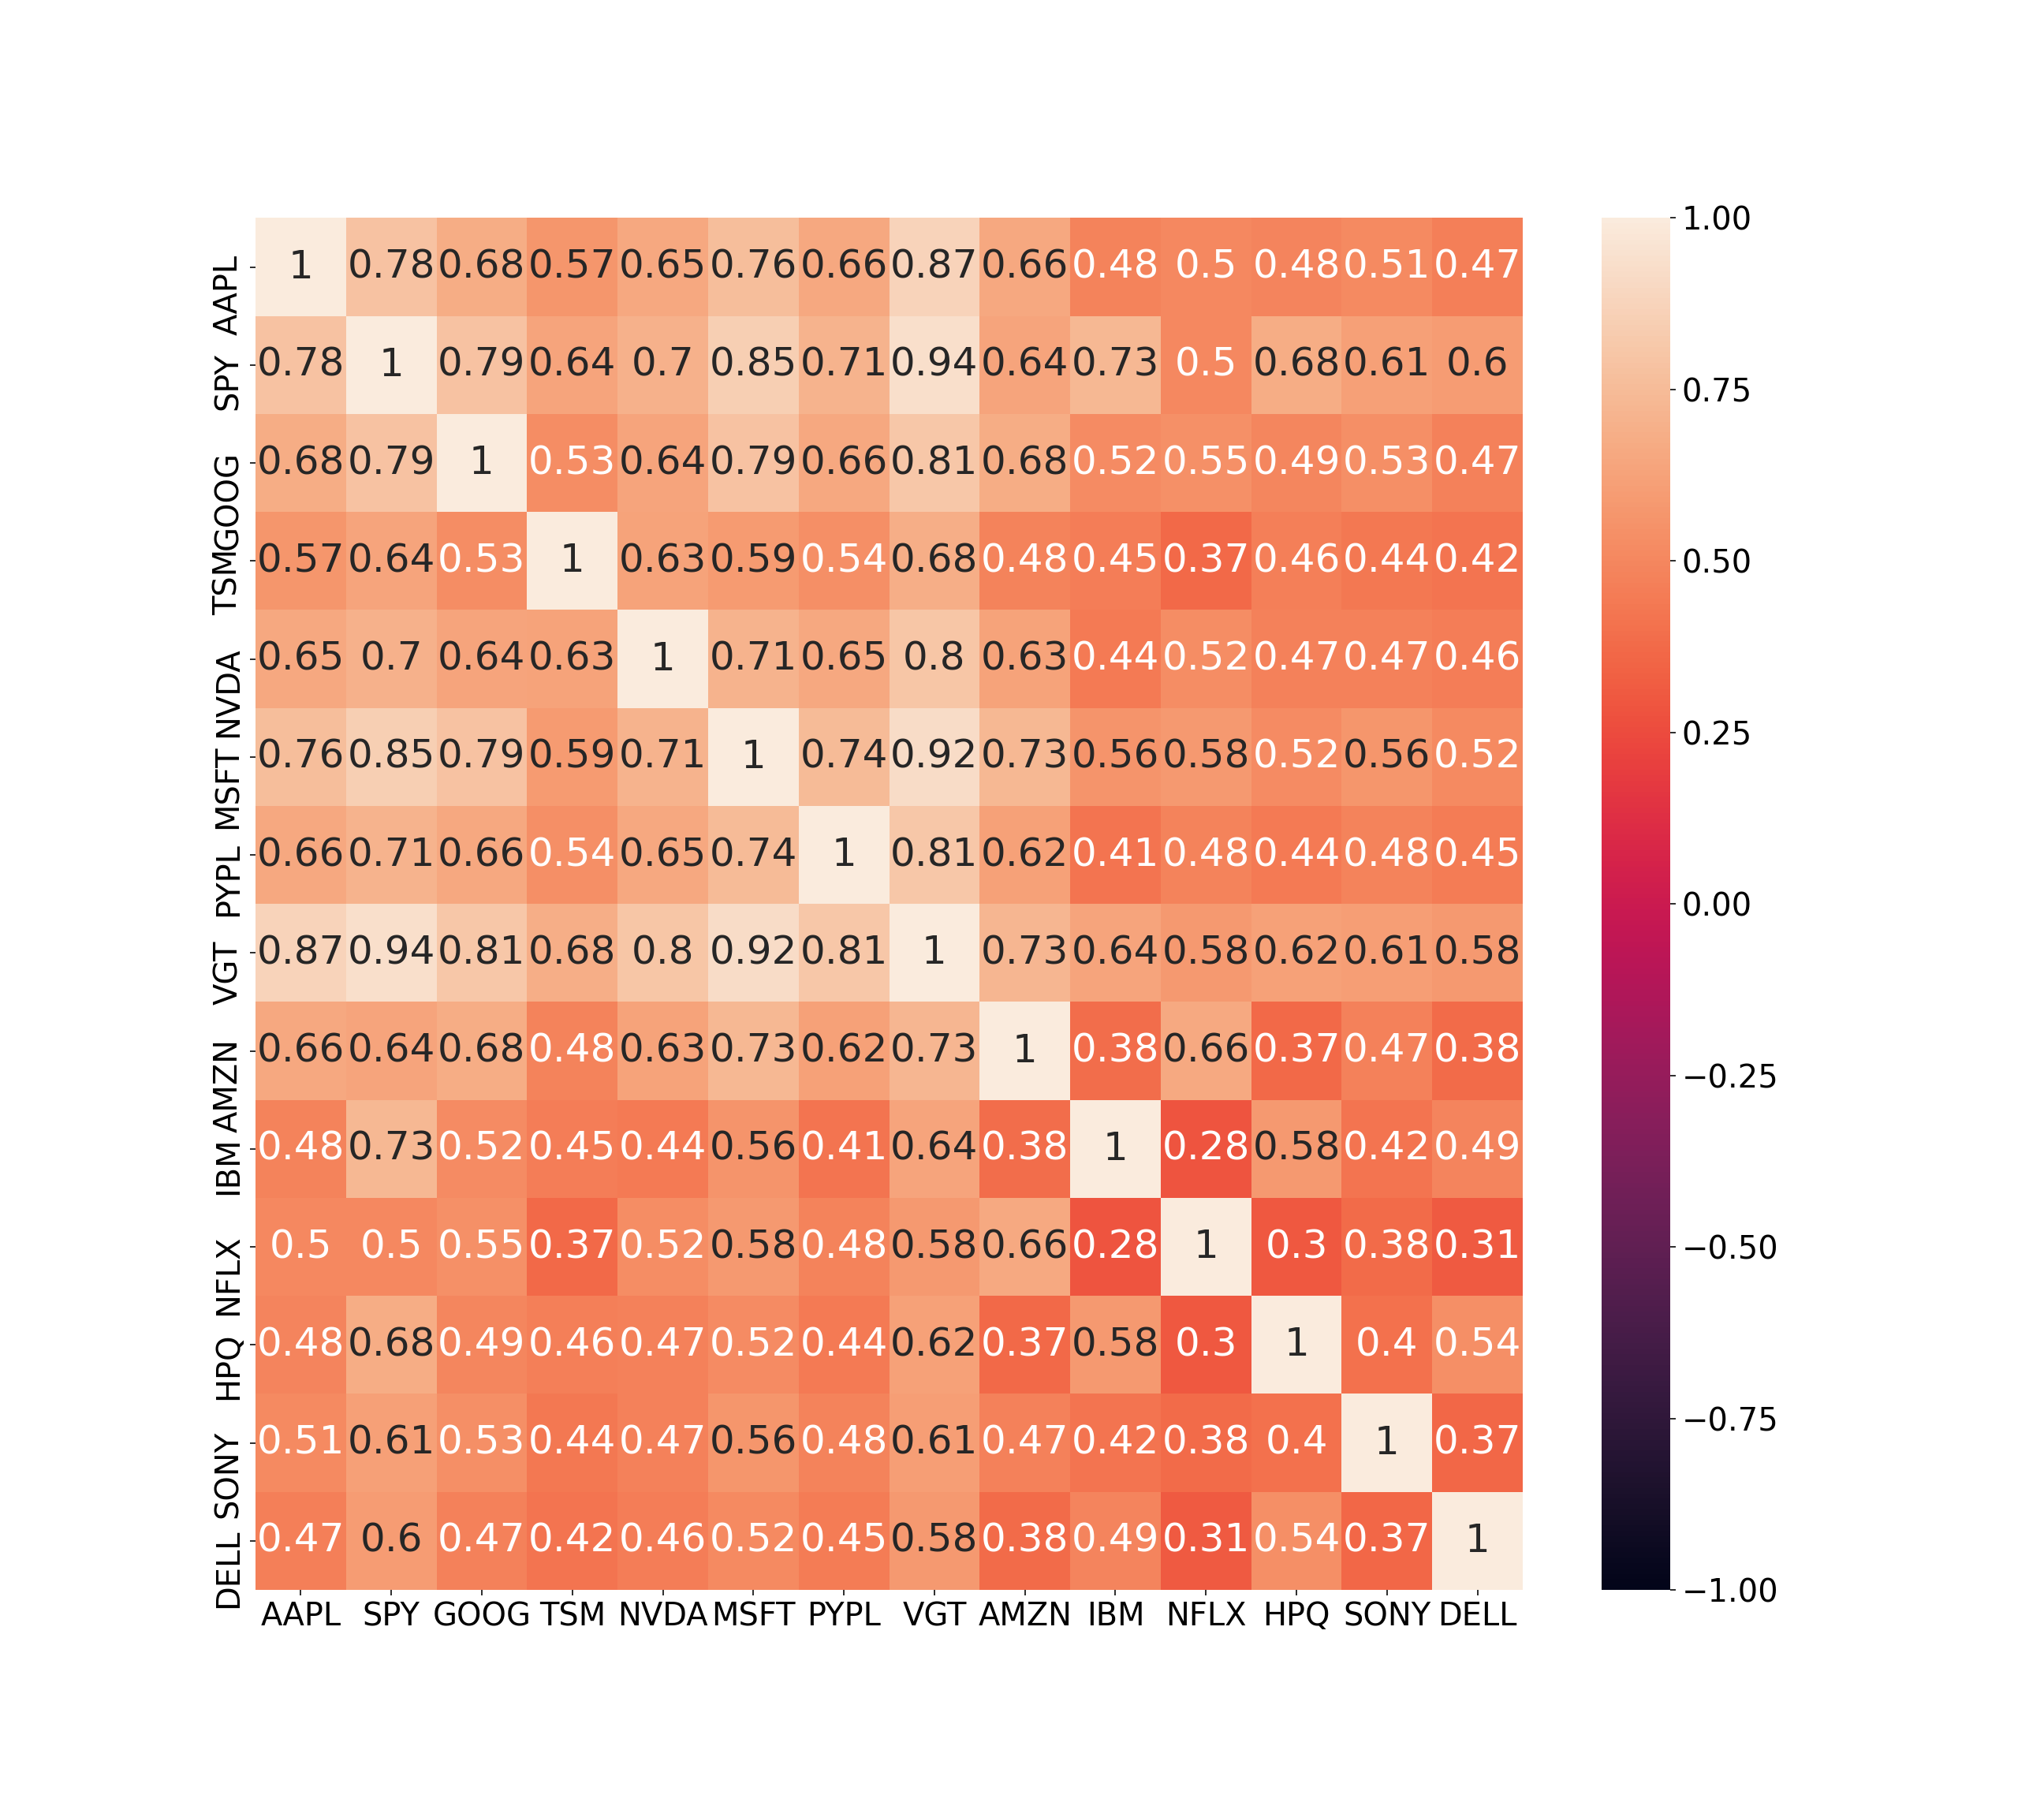

In [72]:
# Serve the# dashboard
panel.servable()

## PyFlux Model

In [73]:
# PyFlux Model
# Load the AAPL closing prices
df = pd.DataFrame()
df['AAPL'] = (set_stocks())['AAPL']
df.head()

AAPL
Date                 
2018-01-02  43.064999
2018-01-03  43.057499
2018-01-04  43.257500
2018-01-05  43.750000
2018-01-08  43.587502

In [74]:
# Calculate the returns for AAPL stock
returns = pd.DataFrame(np.diff(np.log(df['AAPL'].values)))
returns.index = df.index.values[1:df.index.values.shape[0]]
returns.columns = ['AAPL Returns']
returns.head()

AAPL Returns
2018-01-03     -0.000174
2018-01-04      0.004634
2018-01-05      0.011321
2018-01-08     -0.003721
2018-01-09     -0.000115

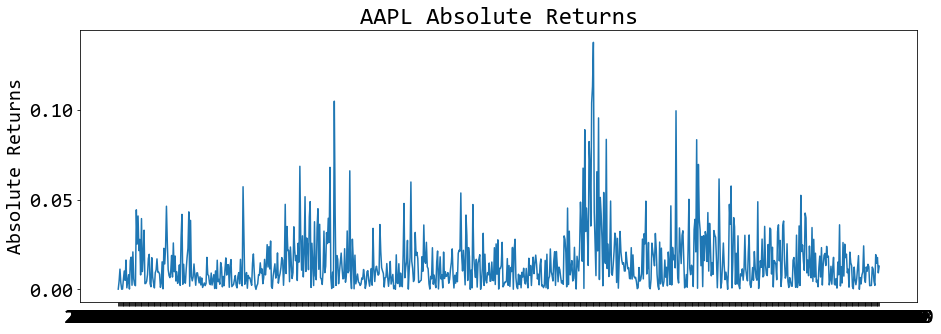

In [75]:
#visualize the underlying volatility of the series is to plot the absolute returns
plt.figure(figsize=(15,5))
plt.plot(returns.index, np.abs(returns))
plt.ylabel('Absolute Returns')
plt.title('AAPL Absolute Returns');

In [76]:
# Beta-t-EGARCH(1,1) model using a point mass estimate:
model = pf.EGARCH(returns, p=1, q=1)
x = model.fit()
x.summary()

EGARCH(1,1)                                                                                               
======================================================= ==================================================
Dependent Variable: AAPL Returns                        Method: MLE                                       
Start Date: 2018-01-04                                  Log Likelihood: 2295.6146                         
End Date: 2021-07-09                                    AIC: -4581.2292                                   
Number of observations: 884                             BIC: -4557.307                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Vol Constant                             -0.3973    0.0775     -5.1281  0.0      (-0.5492 | -0.2455)      
p(1)                                 

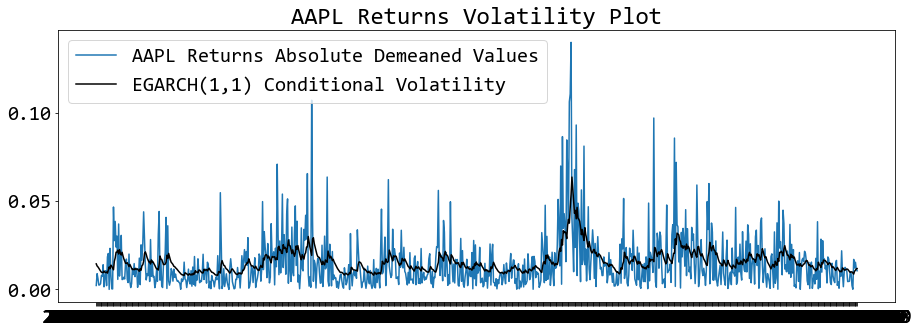

In [77]:
# plot the fit
model.plot_fit(figsize=(15,5))

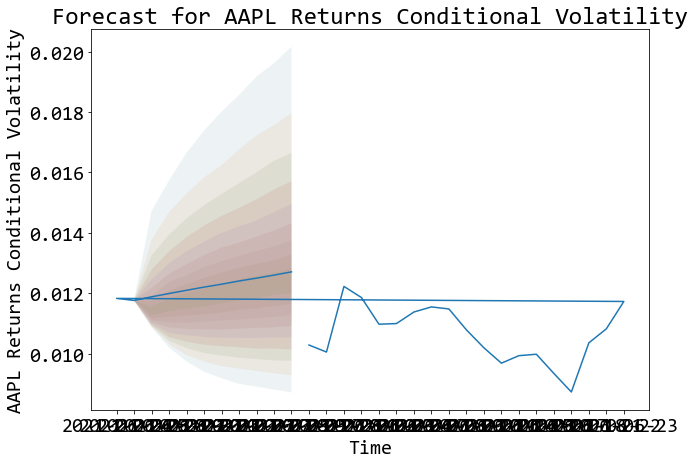

In [78]:
# plot predictions of future conditional volatility
model.plot_predict(h=10)

In [ ]:
# visiluze how well model predicted using in-sample rolling prediction
model.plot_predict_is(h=50,figsize=(15,5))

In [ ]:
# estimate a Beta-t-EGARCH model with leverage
model.add_leverage()
x = model.fit()
x.summary()

## Trading Bot and Automation

In [73]:
# This API below was created by us on Google cloud functions and automate and
# streamlines the buying and selling orders at Alpaca.
# If you noticed we are not using the API keys for ALPACA at this moment cause they are in Cloud

In [74]:

API_ENDPOINT = "https://us-central1-alpaca-project-beta.cloudfunctions.net/alpaca"
def alpaca(symbol,qty,side,type,time_in_force):
  data =  {
          "symbol": symbol,
          "qty": qty,
          "side": side,
          "type": type,
          "time_in_force": time_in_force     
          }
  r = requests.post(url = API_ENDPOINT, json = data)
  print(r.status_code)
  print(r.json()['status'])
  print(r.json())
  return 

In [75]:
# Daily order based on on Buy Sell Signal

In [76]:
from time import sleep
sleep(5) # in a normal day we would use 7200 seconds to avoid opening volatility

In [77]:
if combined_mixed['Entry/Exit'][-1] < 0:
    alpaca("AAPL",3,"buy","market","gtc")
elif combined_mixed['Entry/Exit'][-1] > 0:
    alpaca("AAPL",3,"buy","market","gtc")
else:
    print('Hold')

Hold


In [78]:
# Intraday Order using quotes from Yticker web socket = Buy or sell if up or down 5% compared to the last day close

In [79]:


project_folder = os.path.expanduser('../')  # adjust as appropriate
load_dotenv(os.path.join(project_folder, 'alpaca.env'))

ALPACA_API_KEY = os.getenv("ALPACA_API_KEY")
ALPACA_SECRET_KEY = os.getenv("ALPACA_SECRET_KEY")

print(ALPACA_API_KEY)

api = tradeapi.REST(
    ALPACA_API_KEY,
    ALPACA_SECRET_KEY,
    'https://paper-api.alpaca.markets'
)
# Get account info
account = api.get_account()


PK8ERMFHZ94CCOX7EKPC


In [80]:
stock_position = api.get_position('AAPL')
account = api.get_account()


In [81]:
cash = float(account.cash)
stock_last_day_close = float(stock_position.lastday_price)
current_stock_number = float(stock_position.qty)
stock_price_current= float(stock_position.current_price)
wallet = float(account.portfolio_value)
buyable_stocks = int(cash/stock_price_current)

In [82]:
cash

98801.26

In [83]:

AAPL = []

# this function is called on each ticker update
def on_new_msg(ws, msg):
    print(msg)
    AAPL.append(msg)
    print(AAPL[0]["price"])
    if cash > 2000:
        if msg.price < 0.95*combined_mixed['Close'][-1]:
            alpaca("AAPL",3,"buy","market","gtc")
        elif msg.price > 1.05*combined_mixed['Close'][-1]:
            alpaca("AAPL",3,"sell","market","gtc")
    return AAPL

yliveticker.YLiveTicker(on_ticker=on_new_msg, ticker_names=["AAPL"])

In [91]:
cash = float(account.cash)
stock_last_day_close = float(stock_position.lastday_price)
current_stock_number = float(stock_position.qty)
stock_price_current= float(stock_position.current_price)
wallet = float(account.portfolio_value)
buyable_stocks = int(cash/stock_price_current)

In [92]:
print(cash)

98801.26


In [93]:
print(stock_last_day_close)

149.15


In [94]:
print(current_stock_number)

27.0


In [95]:
print(stock_price_current)

148.07


In [96]:
print(wallet)

105690.25


In [97]:
print(buyable_stocks)

667
